# Dummy Classifier - Baseline Model

This notebook establishes baseline performance using DummyClassifier for the credit scoring task.

## Overview
- **Purpose**: Establish baseline metrics that any real model should beat
- **Models**: DummyClassifier with strategies: stratified, most_frequent, prior
- **Evaluation**: 5-Fold Cross-Validation
- **Tracking**: MLflow for experiment tracking

## Business Context
- False Negative (FN): Missing a default → Cost = 10
- False Positive (FP): Rejecting a good client → Cost = 1
- Total Cost = 10 × FN + 1 × FP

A baseline helps us understand:
1. The minimum AUC we should expect (≈0.5 for random)
2. The business cost if we made no predictions
3. How class imbalance affects naive approaches


## 1. Setup and Configuration


In [1]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

from src.utils.notebook_mlflow import NotebookMLFlow
import mlflow



print(f"Tracking URI will be: sqlite:///{Path('../src/utils/notebook_mlflow.py').resolve().parent.parent.parent}/mlruns/mlflow.db")

Tracking URI will be: sqlite:////Users/hamzaboualam/Downloads/OpenClassRoom- projects/P7/mlruns/mlflow.db


In [2]:


import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Project utilities
from src.utils.notebook_mlflow import quick_mlflow_setup, FN_COST, FP_COST
from src.utils.feature_io import load_features_pickle, split_train_val_test, save_data_splits

# Configuration
RANDOM_STATE = 42
N_FOLDS = 5

print("✅ Imports complete")
print(f"   Random State: {RANDOM_STATE}")
print(f"   CV Folds: {N_FOLDS}")
print(f"   Business Cost: {FN_COST}×FN + {FP_COST}×FP")


✅ Imports complete
   Random State: 42
   CV Folds: 5
   Business Cost: 10.0×FN + 1.0×FP


In [3]:
# Initialize MLflow tracker
mlflow_tracker = quick_mlflow_setup("credit-scoring-baseline")
print("✅ MLflow tracker ready")


2026/01/08 12:19:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 12:19:27 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


✅ MLFlow configuré - Expérience: credit-scoring-baseline
✅ MLflow tracker ready


## 2. Load and Split Data


In [4]:
# Load processed features
FEATURES_PATH = Path("../data/processed/features_train.pkl")

if not FEATURES_PATH.exists():
    raise FileNotFoundError(
        f"Features not found at {FEATURES_PATH}. "
        "Please run 02_feature_engineering.ipynb first."
    )

df = load_features_pickle(input_dir="../data/processed", filename="features_train.pkl")

print(f"\n📊 Target distribution:")
print(df['TARGET'].value_counts())
print(f"\n📊 Class imbalance ratio: {(df['TARGET'] == 0).sum() / (df['TARGET'] == 1).sum():.2f}:1")


✅ Loaded features from: ../data/processed/features_train.pkl
   Shape: (307507, 765)

📊 Target distribution:
TARGET
0    282682
1     24825
Name: count, dtype: int64

📊 Class imbalance ratio: 11.39:1


In [5]:
# Split data: 60% Train / 20% Validation / 20% Test
splits = split_train_val_test(
    df,
    target_col="TARGET",
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

# Extract splits
X_train = splits["X_train"]
y_train = splits["y_train"]
X_val = splits["X_val"]
y_val = splits["y_val"]
X_test = splits["X_test"]
y_test = splits["y_test"]
feature_names = splits["feature_names"]

# Save splits for use in other notebooks
save_data_splits(splits, output_dir="../data/processed")
print("\nData splits saved for reproducibility across notebooks")


DATA SPLIT SUMMARY
  Total samples:    307,507
  Training set:     184,503 (60.0%)
  Validation set:   61,502 (20.0%)
  Test set:         61,502 (20.0%)
  Number of features: 763

Positive rates (class=1):
  Train: 8.07%
  Val:   8.07%
  Test:  8.07%
✅ Data splits saved to: ../data/processed/data_splits.pkl

Data splits saved for reproducibility across notebooks


## 3. Define Dummy Classifier Strategies

We'll test three different strategies:
1. **stratified**: Generates predictions based on class distribution
2. **most_frequent**: Always predicts the majority class (0 = No Default)
3. **prior**: Returns class probabilities based on training distribution


In [6]:
# Define baseline models
dummy_strategies = [
    {
        "name": "DummyClassifier_stratified",
        "model": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),
        "description": "Random predictions respecting class distribution",
        "params": {"strategy": "stratified", "random_state": RANDOM_STATE}
    },
    {
        "name": "DummyClassifier_most_frequent",
        "model": DummyClassifier(strategy="most_frequent"),
        "description": "Always predicts majority class (No Default)",
        "params": {"strategy": "most_frequent"}
    },
    {
        "name": "DummyClassifier_prior",
        "model": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
        "description": "Returns class probabilities based on training priors",
        "params": {"strategy": "prior", "random_state": RANDOM_STATE}
    }
]

print("📊 Baseline strategies defined:")
for strategy in dummy_strategies:
    print(f"   - {strategy['name']}: {strategy['description']}")


📊 Baseline strategies defined:
   - DummyClassifier_stratified: Random predictions respecting class distribution
   - DummyClassifier_most_frequent: Always predicts majority class (No Default)
   - DummyClassifier_prior: Returns class probabilities based on training priors


## 4. Cross-Validation for Each Strategy

Run 5-fold cross-validation on the training set for each baseline strategy.


In [7]:
# Run cross-validation for each strategy
baseline_results = []

for strategy in dummy_strategies:
    print(f"\n{'='*60}")
    print(f"Evaluating: {strategy['name']}")
    print(f"{'='*60}")
    
    # Run cross-validation with MLflow tracking
    cv_results = mlflow_tracker.cross_validate_model(
        model=strategy["model"],
        X=X_train,
        y=y_train,
        cv=N_FOLDS,
        model_name=strategy["name"],
        params=strategy["params"],
        tags={"baseline": "true", "strategy": strategy["params"]["strategy"]},
        log_to_mlflow=True,
        create_plots=True
    )
    
    baseline_results.append({
        "name": strategy["name"],
        "description": strategy["description"],
        "results": cv_results
    })

print("\n All baseline strategies evaluated")



Evaluating: DummyClassifier_stratified

CROSS-VALIDATION: DummyClassifier_stratified (5 folds)
  Fold 1/5: AUC=0.4973, Acc=0.8513, Cost=30281 (0.5s)
  Fold 2/5: AUC=0.4994, Acc=0.8519, Cost=30160 (0.3s)
  Fold 3/5: AUC=0.4961, Acc=0.8510, Cost=30358 (0.4s)
  Fold 4/5: AUC=0.5019, Acc=0.8527, Cost=30006 (0.4s)
  Fold 5/5: AUC=0.5030, Acc=0.8530, Cost=29940 (0.4s)

RESULTS: DummyClassifier_stratified
  AUC:           0.4995 ± 0.0026
  Accuracy:      0.8520 ± 0.0008
  Business Cost: 30149.0 ± 158.3
  Optimal Threshold: 0.010 (Cost: 150745.0)
  Training Time: 2.1s

✅ Logged to MLflow: DummyClassifier_stratified

Evaluating: DummyClassifier_most_frequent

CROSS-VALIDATION: DummyClassifier_most_frequent (5 folds)
  Fold 1/5: AUC=0.5000, Acc=0.9193, Cost=29790 (1.0s)
  Fold 2/5: AUC=0.5000, Acc=0.9193, Cost=29790 (1.0s)
  Fold 3/5: AUC=0.5000, Acc=0.9193, Cost=29790 (1.2s)
  Fold 4/5: AUC=0.5000, Acc=0.9193, Cost=29790 (2.7s)
  Fold 5/5: AUC=0.5000, Acc=0.9193, Cost=29790 (2.1s)

RESULTS: Du

## 5. Results Summary


In [8]:
# Create comparison DataFrame
comparison_data = []
for result in baseline_results:
    r = result["results"]
    comparison_data.append({
        "Model": result["name"],
        "Strategy": result["description"],
        "CV AUC Mean": r["cv_auc_mean"],
        "CV AUC Std": r["cv_auc_std"],
        "CV Accuracy Mean": r["cv_accuracy_mean"],
        "CV Accuracy Std": r["cv_accuracy_std"],
        "CV Business Cost Mean": r["cv_business_cost_mean"],
        "CV Business Cost Std": r["cv_business_cost_std"],
        "Optimal Threshold": r["optimal_threshold"],
        "Optimal Cost": r["optimal_business_cost"]
    })

baseline_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("BASELINE RESULTS SUMMARY")
print("=" * 80)
print(baseline_df[["Model", "CV AUC Mean", "CV Accuracy Mean", "CV Business Cost Mean"]].to_string(index=False))
print("=" * 80)


BASELINE RESULTS SUMMARY
                        Model  CV AUC Mean  CV Accuracy Mean  CV Business Cost Mean
   DummyClassifier_stratified     0.499533          0.851981                30149.0
DummyClassifier_most_frequent     0.500000          0.919270                29790.0
        DummyClassifier_prior     0.500000          0.919270                29790.0


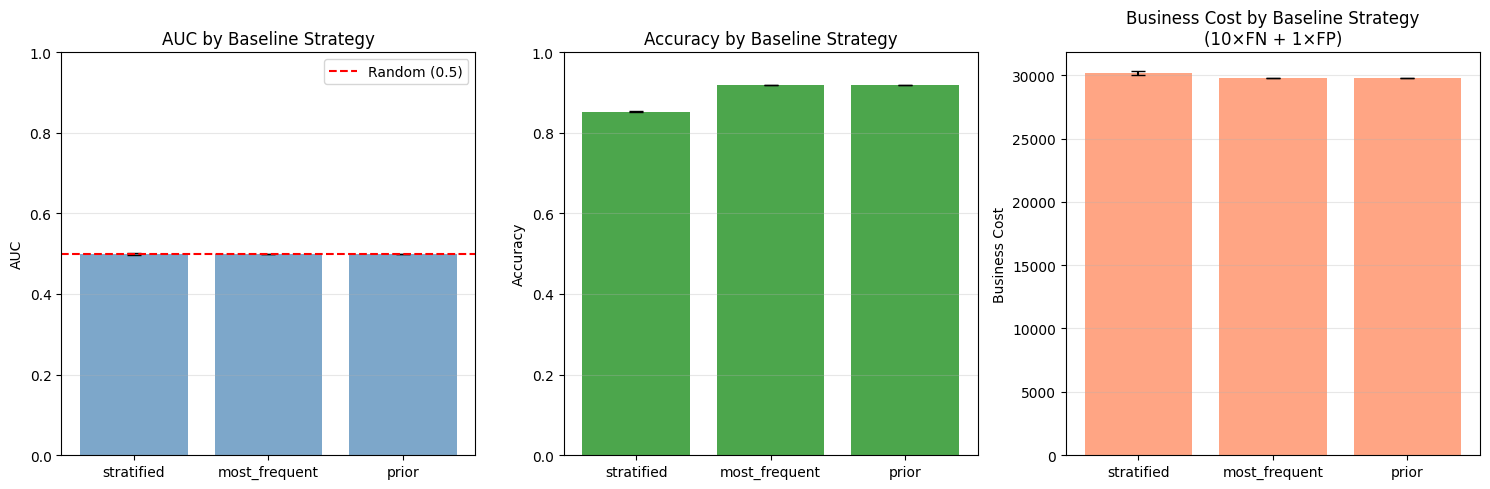


✅ Comparison chart saved to: data/processed/baseline_comparison.png


In [9]:
# Visualize baseline comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = [r["name"].replace("DummyClassifier_", "") for r in baseline_results]

# AUC Comparison
ax1 = axes[0]
auc_means = [r["results"]["cv_auc_mean"] for r in baseline_results]
auc_stds = [r["results"]["cv_auc_std"] for r in baseline_results]
bars1 = ax1.bar(strategies, auc_means, yerr=auc_stds, capsize=5, color='steelblue', alpha=0.7)
ax1.axhline(y=0.5, color='red', linestyle='--', label='Random (0.5)')
ax1.set_ylabel('AUC')
ax1.set_title('AUC by Baseline Strategy')
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Accuracy Comparison
ax2 = axes[1]
acc_means = [r["results"]["cv_accuracy_mean"] for r in baseline_results]
acc_stds = [r["results"]["cv_accuracy_std"] for r in baseline_results]
bars2 = ax2.bar(strategies, acc_means, yerr=acc_stds, capsize=5, color='green', alpha=0.7)
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Baseline Strategy')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Business Cost Comparison
ax3 = axes[2]
cost_means = [r["results"]["cv_business_cost_mean"] for r in baseline_results]
cost_stds = [r["results"]["cv_business_cost_std"] for r in baseline_results]
bars3 = ax3.bar(strategies, cost_means, yerr=cost_stds, capsize=5, color='coral', alpha=0.7)
ax3.set_ylabel('Business Cost')
ax3.set_title('Business Cost by Baseline Strategy\n(10×FN + 1×FP)')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Comparison chart saved to: data/processed/baseline_comparison.png")


## 6. Save Baseline Metrics for Model Comparison


In [10]:
# Save baseline metrics for reference in other notebooks
baseline_metrics = {
    "stratified": baseline_results[0]["results"],
    "most_frequent": baseline_results[1]["results"],
    "prior": baseline_results[2]["results"]
}

# Save to pickle for later use
baseline_path = Path("../data/processed/baseline_metrics.pkl")
with open(baseline_path, 'wb') as f:
    pickle.dump(baseline_metrics, f)

print(f"✅ Baseline metrics saved to: {baseline_path}")
print("\n📊 These metrics will be used to compare real models:")
print(f"   - Minimum AUC to beat: {baseline_metrics['stratified']['cv_auc_mean']:.4f} (stratified)")
print(f"   - Baseline business cost: {baseline_metrics['most_frequent']['cv_business_cost_mean']:.1f} (most_frequent)")


✅ Baseline metrics saved to: ../data/processed/baseline_metrics.pkl

📊 These metrics will be used to compare real models:
   - Minimum AUC to beat: 0.4995 (stratified)
   - Baseline business cost: 29790.0 (most_frequent)


## 7. MLflow UI Access


In [11]:
# Display MLflow UI information
mlflow_tracker.show_ui_info()


🌐 Interface MLFlow disponible sur: http://localhost:5000
📊 Pour démarrer l'interface (avec le bon backend SQLite), exécutez dans le terminal:
   source .venv/bin/activate && mlflow ui --backend-store-uri "sqlite:////Users/hamzaboualam/Downloads/OpenClassRoom- projects/P7/mlruns/mlflow.db" --host 127.0.0.1 --port 5000

📈 Vous pouvez maintenant:
   - Voir toutes vos expérimentations
   - Comparer les métriques
   - Visualiser les graphiques
   - Télécharger les modèles
   - Gérer le registry des modèles


## Summary

### Key Findings

1. **AUC Baseline**: The stratified DummyClassifier achieves ~0.50 AUC, which is what we expect from random predictions.

2. **Accuracy Trap**: The most_frequent strategy achieves ~92% accuracy by always predicting "No Default", but this is misleading due to class imbalance.

3. **Business Cost**: The baseline business cost comes from predicting all as non-default (missing all actual defaults), which incurs 10× penalty per missed default.

### Interpretation

- **Any real model should achieve AUC > 0.5** (ideally > 0.7)
- **Business cost should be significantly lower** than the baseline
- **High accuracy alone is not sufficient** due to class imbalance

### Next Steps

1. Run `04_random_forest.ipynb` for Random Forest with CV and Optuna tuning
2. Run `05_lightgbm.ipynb` for LightGBM with CV and Optuna tuning
3. Compare all models using MLflow UI
